In [2]:
#### Dependencies
import pandas as pd
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

#### Pre-process_Reservoir Volume Data

In [ ]:
#### Function to Process Reservoir Volumes
def process_and_merge_data(file_paths, start_year, end_year, output_file):
    data_frames = []
        for name, path in file_paths.items():
        # Read each file
        df = pd.read_csv(path)
        
        # Extract year, month, and day from the "Time" column
        df['Time'] = pd.to_datetime(df['Time'])
        df['Year'] = df['Time'].dt.year
        df['Month'] = df['Time'].dt.month
        df['Day'] = df['Time'].dt.day
        
        # Clip data based on year range
        df = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]
        
        # Add Julian day column
        df['Julian_Day'] = df['Time'].dt.dayofyear
        
        # Rename volume column to file name
        df.rename(columns={df.columns[1]: name}, inplace=True)
        
        # Keep relevant columns
        data_frames.append(df[['Year', 'Month', 'Day', 'Julian_Day', name]])

    # Merge all data on Year, Month, Day, and Julian_Day
    merged_data = data_frames[0]
    for df in data_frames[1:]:
        merged_data = pd.merge(merged_data, df, on=['Year', 'Month', 'Day', 'Julian_Day'], how='outer')

    # Interpolate missing values
    merged_data.interpolate(method='linear', inplace=True, limit_direction='both')

    # Save the final merged and processed data
    merged_data.to_csv(output_file, index=False)

    return output_file

file_paths = {
    "Aursojen": "./Input_Data/Rawdata/Aursojen_volume(1966-2020).csv",
    "Breidalsvatnet": "./Input_Data/Rawdata/Breidalsvatnet_volume(1960-2020).csv",
    "Rauddalsvatnet": "./Input_Data/Rawdata/Rauddalsvatnet_volume(1960-2020).csv",
    "Tesse": "./Input_Data/Rawdata/Tesse_volume(1960-2020).csv"
}

output_file = "/Input_Data/Water/Reservoir_Volumes.csv"
start_year = 2000
end_year = 2020

process_and_merge_data(file_paths, start_year, end_year, output_file)

### Energy Storage

In [3]:
# Input and Output Paths
volume_data_file = "./Input_Data/Water/Reservoir_Volumes.csv"
energy_data_file = "./Input_Data/Energy/Energy_Scape.xlsx"

# Output file paths
output_mean_annual = "./Outputs/Energy/Mean_Annual_Storage.csv"
output_cell_grid = "./Outputs/Energy/Mean_Storage_Per_Cell.csv"
storage_output_file = "./Outputs/Energy/energy_storage_data.csv"


# Energy Storage Calculation Function
def energy_storage(volume_data_file, energy_data_file, storage_output_file):
    # Read volume data
    volume_data = pd.read_csv(volume_data_file)
    
    # Convert all volume columns to cubic meters (from million m³)
    for col in volume_data.columns[4:]:  # Assuming first 4 columns are 'Year', 'Month', 'Day', 'Julian_Day'
        volume_data[col] *= 1e6  # Converting from million cubic meters to cubic meters
    
    # Read storage data
    storage_data = pd.read_excel(energy_data_file, sheet_name="Storage")
    
    # Initialize the energy_storage_data DataFrame with date-related columns
    energy_storage_data = volume_data[['Year', 'Month', 'Day', 'Julian_Day']].copy()

    # Loop through each reservoir and calculate Hold_Energy
    for _, row in storage_data.iterrows():
        reservoir = row["Res_Id"]
        hold_start = row["Hold_Start"]
        hold_end = row["Hold_End"]
        height = row["Height"]

        # Split hold period
        volume_data[f'{reservoir}_Hold'] = volume_data.apply(
            lambda r: r[reservoir] if hold_start <= r['Julian_Day'] <= hold_end else 0, axis=1
        )

        # Calculate hold energy
        energy_storage_data[f'{reservoir}_Hold_Energy'] = (
            volume_data[f'{reservoir}_Hold'] * 998 * 9.8 * height
        ) / 1e6  # Convert energy to GWh

    # Save to file
    energy_storage_data.to_csv(storage_output_file, index=False)
    print(f"Energy storage data saved to {storage_output_file}.")

    return energy_storage_data


# Calculate energy storage by calling above function (energy_storage)
final_storage_data = energy_storage(volume_data_file, energy_data_file, storage_output_file)


# Calculate Mean Annual storage
annual_storage = final_storage_data.groupby('Year').mean(numeric_only=True)
annual_storage.to_csv(output_mean_annual)
print(f"Mean annual storage saved to: {output_mean_annual}")

# Step 3: Read Cell_IDs and source mapping from the Storage sheet
cell_mapping = pd.read_excel(energy_data_file, sheet_name="Storage")

# Initialize grid cells (1 to 9440)
num_cells = 9440
cell_grid = pd.DataFrame({"Cell_ID": range(1, num_cells + 1)})

# Calculate mean stored energy for each reservoir
source_totals = final_storage_data.mean(numeric_only=True)

# Initialize a column for the total sum of all reservoirs
cell_grid["Total_Storage"] = 0  # This will store the sum of energy values for each Cell_ID

# Map mean stored energy to grid cells for storage
for _, row in cell_mapping.iterrows():
    reservoir_with_suffix = f"{row['Res_Id']}_Hold_Energy"  # Match the column name in storage data
    if reservoir_with_suffix in source_totals.index:
        # Get the list of Cell_IDs
        cell_ids = row["Cell_ID"]
        if isinstance(cell_ids, str):
            # Convert string representation of list to actual list
            cell_ids = eval(cell_ids)  # Use eval carefully; it assumes the input is properly formatted

        # Calculate the mean stored energy for this reservoir
        mean_energy = source_totals[reservoir_with_suffix] / len(cell_ids)

        # Distribute the energy equally among the cells and add to total storage
        for cell_id in cell_ids:
            cell_grid.loc[cell_grid["Cell_ID"] == cell_id, "Total_Storage"] += mean_energy
    else:
        print(f"Warning: Source '{reservoir_with_suffix}' not found in source_totals.")

# Fill NaN values with 0 (just in case)
cell_grid.fillna(0, inplace=True)

# Save grid-based storage data
cell_grid.to_csv(output_cell_grid, index=False)
print(f"Storage per cell saved to: {output_cell_grid}")



Energy storage data saved to ./Outputs/Energy/energy_storage_data.csv.
Mean annual storage saved to: ./Outputs/Energy/Mean_Annual_Storage.csv
Storage per cell saved to: ./Outputs/Energy/Mean_Storage_Per_Cell.csv


#### Energy Production

In [25]:
# Input File Paths
volume_data_file = "./Input_Data/Water/Reservoir_Volumes.csv"
energy_data_file = "./Input_Data/Energy/Energy_Scape.xlsx"
production_data = pd.read_excel(energy_data_file, sheet_name="Production")
storage_data = pd.read_excel(energy_data_file, sheet_name="Storage")

# Output File Paths
production_output_file = "./Outputs/Energy/daily_energy_production_data.csv"
output_total_annual = "./Outputs/Energy/total_annual_production.csv"
output_cell_grid = "./Outputs/Energy/total_production_per_cell.csv"


# Function for Daily Energy Production
def energy_production(volume_data_file, production_data, storage_data):
    # Read the reservoir volume data
    volume_data = pd.read_csv(volume_data_file)
    
    # Convert volume columns to cubic meters (from million m³)
    for col in volume_data.columns[4:]:  # Assuming first 4 columns are 'Year', 'Month', 'Day', 'Julian_Day'
        volume_data[col] *= 1e6 ####Convert in m3

    # Initialize a DataFrame to store energy production data
    energy_production_data = volume_data[['Year', 'Month', 'Day', 'Julian_Day']].copy()

    for _, row in production_data.iterrows():
        HPP = row["Name"]
        energy_equivalent = row["EEQ"]
        reservoir = str(row["Res_Id"])  # Match reservoir column names as strings

        if reservoir in map(str, range(1, 6)):  # Res_Id in range 1 to 5
            storage_row = storage_data[storage_data["Res_Id"] == int(reservoir)]
            if not storage_row.empty:
                hold_start, hold_end = storage_row.iloc[0]["Hold_Start"], storage_row.iloc[0]["Hold_End"]
            else:
                print(f"Hold_Start and Hold_End not found for Reservoir {reservoir}. Skipping...")
                continue

            if reservoir in volume_data.columns:
                # Calculate hold and release periods
                volume_data[f'{reservoir}_Hold'] = volume_data.apply(
                    lambda r: r[reservoir] if hold_start <= r['Julian_Day'] <= hold_end else 0, axis=1
                )
                volume_data[f'{reservoir}_Release'] = volume_data[reservoir] - volume_data[f'{reservoir}_Hold']

                # Calculate daily production
                volume_data[f'{HPP}_Daily_Flow'] = volume_data[f'{reservoir}_Release'].diff().fillna(0).abs()
                volume_data[f'{HPP}_Daily_Production'] = (volume_data[f'{HPP}_Daily_Flow'] * energy_equivalent) / 1e6 # Conversion from KW/m3 to GW/m3
            else:
                print(f"Reservoir {reservoir} not found in volume_data columns. Skipping...")
                continue
        elif reservoir == '0':  # Res_Id is 0
            # Direct production calculation for non-reservoir HPPs
            volume_data[f'{HPP}_Daily_Production'] = (row["Capacity"] * row["Efficiency"] * 0.8 * 24) / 1e3 ##Assuming Daily production to be 80% of total capacity + conversion from MW to GW
        else:
            print(f"Invalid Res_Id value: {reservoir}. Skipping...")
            continue

        # Append only the Daily_Production column for the current HPP
        energy_production_data[f'{HPP}_Daily_Production'] = volume_data[f'{HPP}_Daily_Production']

    # Return the final DataFrame
    print("Energy production data processing completed.")
    return energy_production_data

# Call the energy production function
final_data = energy_production(volume_data_file, production_data, storage_data)

# Save the daily production data
final_data.to_csv(production_output_file, index=False)
print(f"Energy production data saved to {production_output_file}.")


# Aggregation of Production Data
# Calculate total annual production
annual_production = final_data.groupby('Year').sum(numeric_only=True)
annual_production['Total_Production'] = annual_production.iloc[:, 4:].sum(axis=1)
annual_production.to_csv(output_total_annual)
print(f"Total annual production saved to: {output_total_annual}")

# Read Cell_IDs and source mapping from the Production sheet
cell_mapping = production_data

# Initialize grid cells (1 to 9440)
num_cells = 9440
cell_grid = pd.DataFrame({"Cell_ID": range(1, num_cells + 1)})

# Calculate total production for each source
production_columns = final_data.iloc[:, 4:]  # This selects all columns starting from column 4
# Add the 'Year' column for grouping
production_data = final_data[['Year']].join(production_columns)
# Group by 'Year' and sum for each year
tot_prod = production_data.groupby('Year').sum()
# Calculate the mean of all years for each production source
source_totals = tot_prod.mean(numeric_only=True)

# Map total production to grid cells
for source in cell_mapping["Name"]:
    # Add the suffix "_Daily_Production" to match source_totals
    source_with_suffix = f"{source}_Daily_Production"
    if source_with_suffix in source_totals.index:
        # Find the corresponding Cell_ID
        cell_id = cell_mapping.loc[cell_mapping["Name"] == source, "Cell_ID"].values
        if len(cell_id) > 0:
            cell_id = cell_id[0]  # Extract the first (and only) Cell_ID
            cell_grid.loc[cell_grid["Cell_ID"] == cell_id, source] = source_totals[source_with_suffix]
        else:
            print(f"Warning: Cell_ID not found for source '{source}'")
    else:
        print(f"Warning: Source '{source_with_suffix}' not found in source_totals")

# Fill NaN values with 0
cell_grid.fillna(0, inplace=True)
cell_grid['Mean_Annual_Production'] = cell_grid.iloc[:, 2:].sum(axis=1)

# Save grid-based production data
cell_grid.to_csv(output_cell_grid, index=False)
print(f"Production per cell saved to: {output_cell_grid}")



Energy production data processing completed.
Energy production data saved to ./Outputs/Energy/daily_energy_production_data.csv.
Total annual production saved to: ./Outputs/Energy/total_annual_production.csv
Production per cell saved to: ./Outputs/Energy/total_production_per_cell.csv


#### Population Estimation

In [5]:
# Load population data from a CSV file and calculate growth rates
population_csv = ".\Input_Data\Pop\Pop.csv"  # Path to your CSV file
population_data = pd.read_csv(population_csv)

# Ensure the population data is sorted by year
population_data = population_data.sort_values(by="Year", ascending=True)

# Calculate growth rates as year-over-year percentage changes
population_data["Growth_Rate"] = population_data["Population"].pct_change()

# Convert growth rates to a dictionary for easy access
growth_rates = population_data.set_index("Year")["Growth_Rate"].to_dict()

# Load the population raster for 2024
input_raster = ".\Input_Data\Pop\Otta_Pop_2024.tif"  # Path to the 2024 population raster

# Read the 2024 raster
with rasterio.open(input_raster) as src:
    population_2024 = src.read(1)  # Read the first band
    profile = src.profile  # Get metadata for saving rasters
    rows, cols = population_2024.shape

# Step 3: Back-calculate population rasters and save in a DataFrame
population_df = pd.DataFrame(index=range(rows * cols))

# Flatten the 2024 population raster to a column in the DataFrame
population_df["2024"] = population_2024.flatten()

# Back-calculate population for each year
current_population = population_2024.flatten()  # Start with the 2024 population
for year in range(2024, population_data["Year"].min(), -1):
    if year - 1 in growth_rates:  # Ensure growth rate exists for the year
        growth_rate = growth_rates[year - 1]  # Growth rate for the previous year
        previous_population = current_population / (1 + growth_rate)  # Back-calculate population
        population_df[str(year - 1)] = previous_population
        current_population = previous_population  # Update for the next iteration

# Step 4: Reshape population data for each year
population_df.index.name = "Cell_ID"
population_df.reset_index(inplace=True)

# Save the population DataFrame to a CSV file for future use
output_csv = ".\Outputs\Pop\Tot_Pop.csv"
population_df.to_csv(output_csv, index=False)
print(f"Population data for all years saved to {output_csv}.")


Population data for all years saved to .\Outputs\Pop\Tot_Pop.csv.


##### Energy Consumption

In [10]:
# Paths to input files
population_csv = "./Outputs/Pop/Tot_Pop.csv"  # Population data
residences_raster = "./Input_Data/Pop/Otta_Dwell_2024.tif"
business_raster = "./Input_Data/Pop/Otta_Estab_2024.tif"
agriculture_raster = "./Input_Data/Pop/Otta_Ag_Prop.tif"
forest_raster = "./Input_Data/Pop/Otta_For_Prop.tif"

# Output files
output_residential = "./Outputs/Energy/residential_consumption.csv"
output_business = "./Outputs/Energy/business_consumption.csv"
output_agriculture = "./Outputs/Energy/agriculture_consumption.csv"
output_forest = "./Outputs/Energy/forest_consumption.csv"
output_total = "./Outputs/Energy/total_consumption.csv"
mean_con_per_cell = "./Outputs/Energy/Mean_Consumption_Per_Cell.csv"


# Energy consumption parameters (base year 2024, kWh/day)
E_res_base = 43.8  # Per-capita residential energy consumption
E_bus_base = 75.0  # Energy per business property
E_agr_base = 100.0  # Energy per agricultural property
E_for_base = 15.0  # Energy per forest property

# Load population data
population_data = pd.read_csv(population_csv, index_col="Cell_ID")
population_data.columns = population_data.columns.astype(int)  # Ensure year columns are integers

# Extract years from the population data
years = population_data.columns

# Read raster data as numpy arrays and align with population_data indices
with rasterio.open(residences_raster) as res_src, \
     rasterio.open(business_raster) as bus_src, \
     rasterio.open(agriculture_raster) as agr_src, \
     rasterio.open(forest_raster) as for_src:
    
    # Read raster data as 2D arrays
    residences = res_src.read(1)
    businesses = bus_src.read(1)
    agriculture = agr_src.read(1)
    forest = for_src.read(1)
    
    # Flatten rasters to 1D arrays for processing
    residences_flat = residences.flatten()
    businesses_flat = businesses.flatten()
    agriculture_flat = agriculture.flatten()
    forest_flat = forest.flatten()

    # Map raster indices to population Cell_ID
    cell_ids = np.arange(len(residences_flat))  # Assume a direct mapping of raster cells to Cell_IDs

# Initialize DataFrames for each type of consumption
residential_consumption = pd.DataFrame(index=population_data.index, columns=years)
business_consumption = pd.DataFrame(index=population_data.index, columns=years)
agriculture_consumption = pd.DataFrame(index=population_data.index, columns=years)
forest_consumption = pd.DataFrame(index=population_data.index, columns=years)
total_consumption = pd.DataFrame(index=population_data.index, columns=years)

# Base year population for scaling
P_base = population_data[2024]

# Loop through each year and calculate consumption
for year in years:
    scaling_factor = population_data[year] / P_base  # Scaling factor for property consumption

    # Calculate consumption for each type
    residential_consumption[year] = population_data[year] * E_res_base
    business_consumption[year] = businesses_flat * E_bus_base * scaling_factor.values
    agriculture_consumption[year] = agriculture_flat * E_agr_base * scaling_factor.values
    forest_consumption[year] = forest_flat * E_for_base * scaling_factor.values

    # Calculate total consumption
    total_consumption[year] = (
        residential_consumption[year] +
        business_consumption[year] +
        agriculture_consumption[year] +
        forest_consumption[year]
    )

#### Mean Consumption per cell from 2000 to 2020
columns_to_average = [str(year) for year in range(2000, 2021)]
# Calculate the mean consumption for each cell from 2000 to 2020
total_consumption['Mean_Consumption'] = total_consumption[columns_to_average].mean(axis=1)
# Select only the Cell_ID and Mean_Consumption columns
mean_con = total_consumption[['Cell_ID', 'Mean_Consumption']]

    
    
# Save outputs to CSV
residential_consumption.to_csv(output_residential)
business_consumption.to_csv(output_business)
agriculture_consumption.to_csv(output_agriculture)
forest_consumption.to_csv(output_forest)
total_consumption.to_csv(output_total)
mean_con.to_csv(mean_con_per_cell, index=False)

print("Energy consumption CSV files generated:")
print(f"- Residential: {output_residential}")
print(f"- Business: {output_business}")
print(f"- Agriculture: {output_agriculture}")
print(f"- Forest: {output_forest}")
print(f"- Total: {output_total}")
print(f"Mean consumption per cell saved to: {mean_con_per_cell}")

KeyError: "None of [Index(['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',\n       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',\n       '2018', '2019', '2020'],\n      dtype='object')] are in the [columns]"

### Annual Balance

In [27]:
# File paths
energy_data_file = "./Input_Data/Energy/Energy_Scape.xlsx"
total_annual_production_file = "./Outputs/Energy/Total_Annual_Production.csv"
mean_annual_storage_file = "./Outputs/Energy/Mean_Annual_Storage.csv"
total_consumption_file = "./Outputs/Energy/total_consumption.csv"
annual_balance_output_file = "./Outputs/Energy/Annual_Balance.csv"

# Read data
import_data = pd.read_excel(energy_data_file, sheet_name="Import")
export_data = pd.read_excel(energy_data_file, sheet_name="Export")
annual_production = pd.read_csv(total_annual_production_file)
mean_storage = pd.read_csv(mean_annual_storage_file)
total_consumption = pd.read_csv(total_consumption_file)

# Filter years from 2000 to 2020
years = range(2000, 2021)

# Initialize the annual balance DataFrame
annual_balance = pd.DataFrame({"Year": years})

# Process import data
import_data_filtered = import_data[import_data["Year"].isin(years)]
annual_balance = annual_balance.merge(import_data_filtered, on="Year", how="left")
annual_balance.rename(columns={"Energy_Import(GWH)": "Import"}, inplace=True)

# Process export data
export_data_filtered = export_data[export_data["Year"].isin(years)]
annual_balance = annual_balance.merge(export_data_filtered, on="Year", how="left")
annual_balance.rename(columns={"Energy_Export(GWH)": "Export"}, inplace=True)

# Process production data
annual_production["Total_Production"] = annual_production.iloc[:, 1:].sum(axis=1)
annual_production_filtered = annual_production[annual_production["Year"].isin(years)][["Year", "Total_Production"]]
annual_balance = annual_balance.merge(annual_production_filtered, on="Year", how="left")

# Process storage data
mean_storage["Total_Storage"] = mean_storage.iloc[:, 1:].sum(axis=1)
mean_storage_filtered = mean_storage[mean_storage["Year"].isin(years)][["Year", "Total_Storage"]]
annual_balance = annual_balance.merge(mean_storage_filtered, on="Year", how="left")

# Process consumption data
total_consumption["Total_Consumption"] = total_consumption.iloc[:, 1:].sum(axis=1)  # Sum across rows (cells)
annual_consumption = total_consumption.iloc[:, 1:].sum(axis=0).reset_index()  # Sum across years (columns)
annual_consumption.columns = ["Year", "Total_Consumption"]

# Filter to ensure "Year" contains only numeric values
annual_consumption = annual_consumption[annual_consumption["Year"].str.isdigit()]
annual_consumption["Year"] = annual_consumption["Year"].astype(int)  # Convert to integers

# Filter the data for the desired years
annual_consumption_filtered = annual_consumption[annual_consumption["Year"].isin(years)]

# Merge with the annual balance DataFrame
annual_balance = annual_balance.merge(annual_consumption_filtered, on="Year", how="left")


# Save to CSV
annual_balance.to_csv(annual_balance_output_file, index=False)

print(f"Annual balance data saved to: {annual_balance_output_file}")

Annual balance data saved to: ./Outputs/Energy/Annual_Balance.csv


### Results Plotting

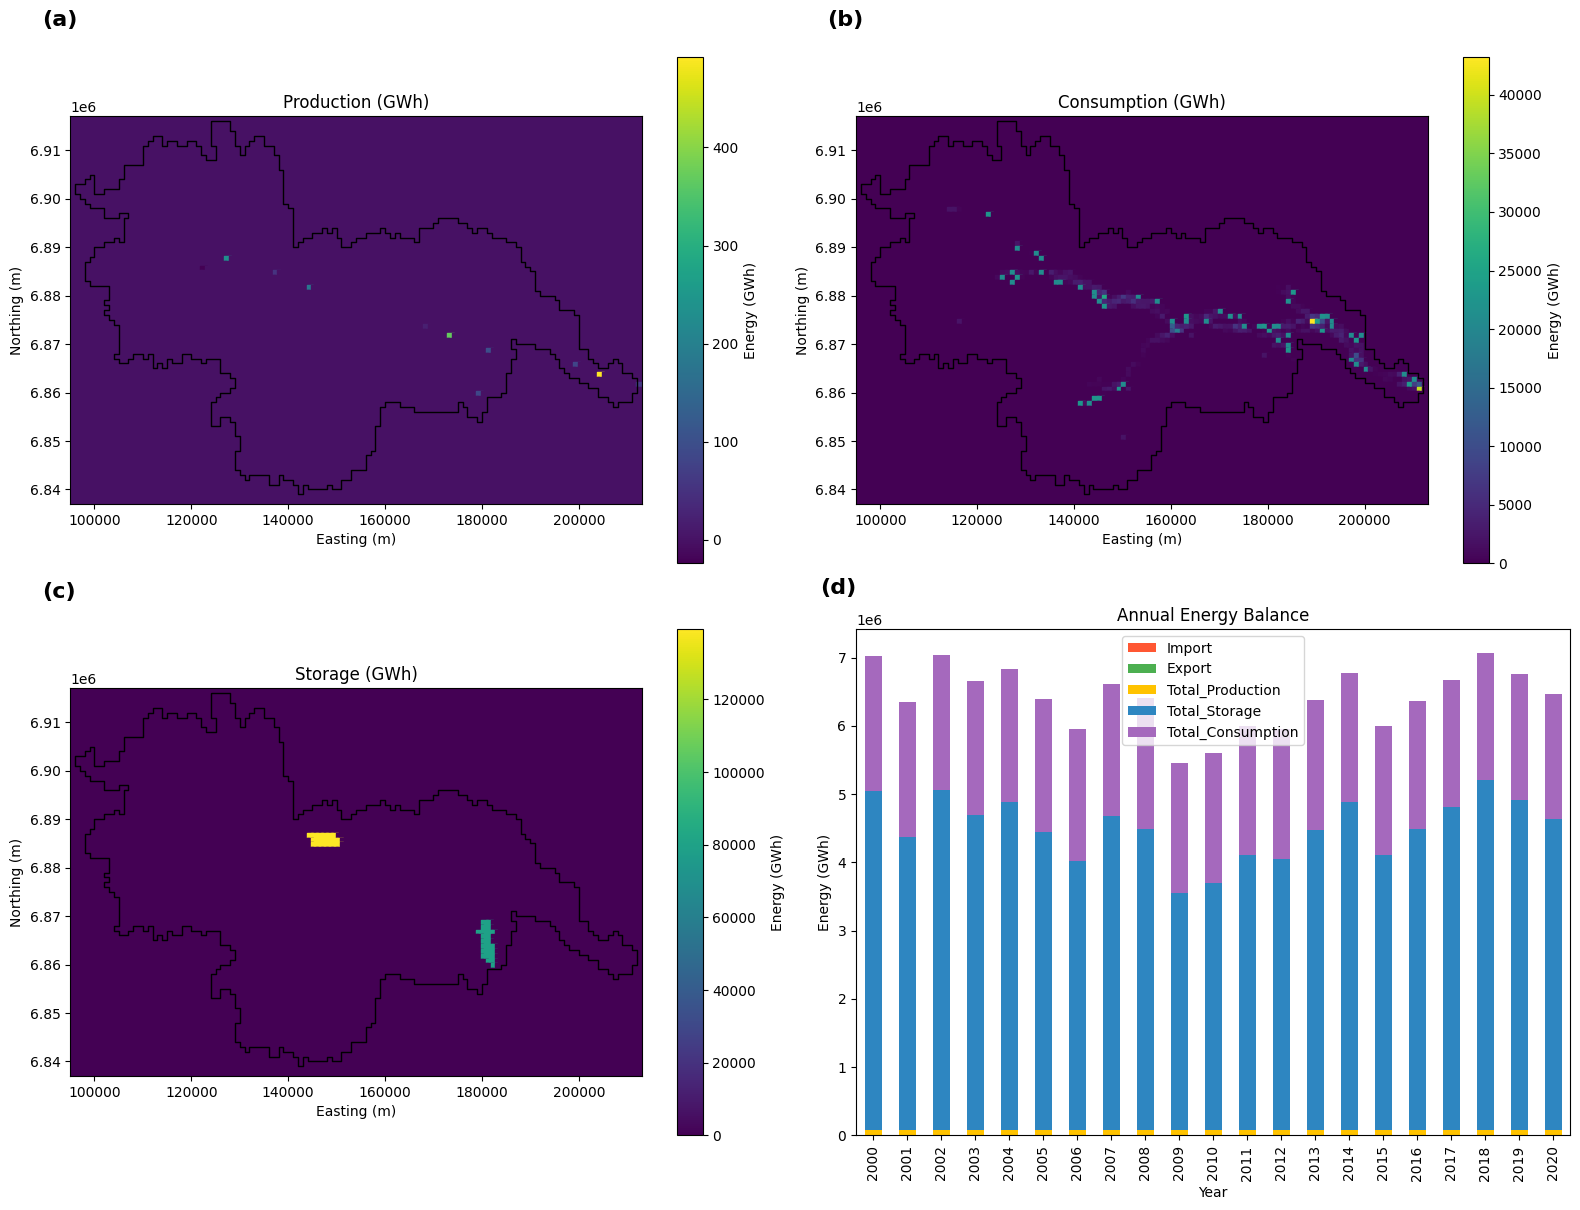

In [32]:
# Input file paths
grid_consumption_file = "./Outputs/Energy/Mean_Consumption_Per_Cell.csv"
grid_production_file = "./Outputs/Energy/total_production_per_cell.csv"
grid_storage_file = "./Outputs/Energy/Mean_Storage_Per_Cell.csv"
boundary_shapefile = "./Input_Data/maps/mask/Otta_mask.shp"
annual_balance_file = "./Outputs/Energy/Annual_Balance.csv"

# CRS and extent
crs = "EPSG:25833"
extent = [95000, 6837000, 213000, 6917000]
cell_size = 1000

# Grid data
grid_consumption = pd.read_csv(grid_consumption_file, usecols=["Cell_ID", "Mean_Consumption"])
grid_production = pd.read_csv(grid_production_file, usecols=["Cell_ID", "Mean_Annual_Production"])
grid_storage = pd.read_csv(grid_storage_file, usecols=["Cell_ID", "Total_Storage"])

# Mask shapefile
boundary = gpd.read_file(boundary_shapefile).to_crs(crs)

# Annual balance data
annual_balance = pd.read_csv(annual_balance_file)

# Grid geometry
n_cols = int((extent[2] - extent[0]) / cell_size)
n_rows = int((extent[3] - extent[1]) / cell_size)
grid_x, grid_y = np.meshgrid(
    np.linspace(extent[0] + cell_size / 2, extent[2] - cell_size / 2, n_cols),
    np.linspace(extent[3] - cell_size / 2, extent[1] + cell_size / 2, n_rows),
)
grid_cells = pd.DataFrame({
    "Cell_ID": range(1, n_cols * n_rows + 1),
    "X": grid_x.flatten(),
    "Y": grid_y.flatten(),
})

# Merge grid data with Cell_ID
consumption_grid = grid_cells.merge(grid_consumption, on="Cell_ID", how="left")
production_grid = grid_cells.merge(grid_production, on="Cell_ID", how="left")
storage_grid = grid_cells.merge(grid_storage, on="Cell_ID", how="left")

# Merged Data
consumption_grid["Mean_Consumption"] = consumption_grid["Mean_Consumption"].fillna(0)
production_grid["Mean_Annual_Production"] = production_grid["Mean_Annual_Production"].fillna(0)
storage_grid["Total_Storage"] = storage_grid["Total_Storage"].fillna(0)

# Plot settings
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
titles = ["Production (GWh)", "Consumption (GWh)", "Storage (GWh)", "Annual Balance"]
data_grids = [
    (production_grid, "Mean_Annual_Production"),
    (consumption_grid, "Mean_Consumption"),
    (storage_grid, "Total_Storage")
]
cmap = "viridis"
stacked_colors = ['#FF5733', '#4CAF50', '#FFC300', '#2E86C1', '#A569BD']
# Panel labels
panel_labels = ['(a)', '(b)', '(c)', '(d)']

# Plot production, consumption, and storage maps
for i, (ax, (data_grid, col)) in enumerate(zip(axes.flat[:3], data_grids)):
    # Handle case where data might be uniform or zero
    if data_grid[col].max() > 0:
        norm = Normalize(vmin=data_grid[col].min(), vmax=data_grid[col].max())
    else:
        norm = Normalize(vmin=0, vmax=1)  # Default range for zero or uniform data

    # Plot grid data
    sc = ax.scatter(
        data_grid["X"], data_grid["Y"],
        c=data_grid[col],
        cmap=cmap,
        s=25,
        marker='s',
        norm=norm
    )
    ax.set_title(titles[i])
    ax.set_xlim(extent[0], extent[2])
    ax.set_ylim(extent[1], extent[3])
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.text(
        -0.05, 1.275, panel_labels[i],
        transform=ax.transAxes, fontsize=16, fontweight='bold',
        va='top', ha='left', color='black'
    )

    # Overlay boundary
    boundary.plot(ax=ax, edgecolor="black", facecolor="none")
    fig.colorbar(sc, ax=ax, orientation="vertical", label="Energy (GWh)")

# Plot annual balance (stacked bar plot)
ax = axes[1, 1]
annual_balance.set_index("Year").plot(
    kind="bar",
    stacked=True,
    ax=ax,
    title="Annual Energy Balance",
    ylabel="Energy (GWh)",
    xlabel="Year",
    color=stacked_colors
)
ax.text(
    -0.05, 1.10, panel_labels[3],
    transform=ax.transAxes, fontsize=16, fontweight='bold',
    va='top', ha='left', color='black'
)



plt.tight_layout()
plt.savefig("./Results/Energy_plot.jpeg", dpi=300, bbox_inches='tight')
plt.show()
 
  
